# Feature Engineering and Modelling

### Import packages

In [269]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt

# Shows plots in jupyter notebook
%matplotlib inline

# Set plot style
sns.set(color_codes=True)

In [270]:
df = pd.read_csv('./clean_data_after_eda.csv')
df["date_activ"] = pd.to_datetime(df["date_activ"], format='%Y-%m-%d')
df["date_end"] = pd.to_datetime(df["date_end"], format='%Y-%m-%d')
df["date_modif_prod"] = pd.to_datetime(df["date_modif_prod"], format='%Y-%m-%d')
df["date_renewal"] = pd.to_datetime(df["date_renewal"], format='%Y-%m-%d')

price_df = pd.read_csv('price_data.csv')
price_df["price_date"] = pd.to_datetime(price_df["price_date"], format='%Y-%m-%d')


In [271]:
df.head()

,Unnamed: 0,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,...,mean_3m_price_p1_var,mean_3m_price_p2_var,mean_3m_price_p3_var,mean_3m_price_p1_fix,mean_3m_price_p2_fix,mean_3m_price_p3_fix,mean_3m_price_p1,mean_3m_price_p2,mean_3m_price_p3,churn
0,0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,...,0.131756,0.092638,0.036909,42.497907,12.218665,8.145777,42.629663,12.311304,8.182687,1
1,1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,...,0.147600,0.000000,0.000000,44.444710,0.000000,0.000000,44.592310,0.000000,0.000000,0
2,2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,...,0.167798,0.088409,0.000000,44.444710,0.000000,0.000000,44.612508,0.088409,0.000000,0
3,3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,...,0.148586,0.000000,0.000000,44.444710,0.000000,0.000000,44.593296,0.000000,0.000000,0
4,4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,...,0.119906,0.101673,0.073719,40.728885,24.437330,16.291555,40.848791,24.539003,16.365274,0


In [272]:
df = df.drop(columns=['Unnamed: 0'])

In [273]:
price_df.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix
0,038af19179925da21a25619c5a24b745,2015-01-01,0.151367,0.0,0.0,44.266931,0.0,0.0
1,038af19179925da21a25619c5a24b745,2015-02-01,0.151367,0.0,0.0,44.266931,0.0,0.0
2,038af19179925da21a25619c5a24b745,2015-03-01,0.151367,0.0,0.0,44.266931,0.0,0.0
3,038af19179925da21a25619c5a24b745,2015-04-01,0.149626,0.0,0.0,44.266931,0.0,0.0
4,038af19179925da21a25619c5a24b745,2015-05-01,0.149626,0.0,0.0,44.266931,0.0,0.0


## Feature Engineering

### Price Sensitivity Features

In order to examine the relationship between price sensitivity and churn, it's necessary to convert the price variables to the difference of price variables.

In this project, there are three ways to build on features of price difference: (mean values are calculated for each client )

1. Price differences across an entire year: Difference between off-peak/peak/mid prices in December and preceding January (yearly change). Reason: For customers who made yearly report may find they have been spending more and more money which may lead to churn.

2. Max price difference between months: Difference between off-peak/peak/mid prices in different months (monthly change). Reason: As a Utilities customer, there is nothing more annoying than sudden price changes between months, and a large increase in prices within a short time span would be an influencing factor in causing me to look at other utilities providers for a better deal.

3. Price differences across different time periods (off_peak, peak, mid_peak): Difference between off_peak and peak which is more significant. Reason: client might want to adjust the deal depending on the time period they are using energy/power. Large price gap may make the clients feel expensive.

#### Price differences across an entire year

In [274]:
# Group off-peak prices by companies and month
monthly_price_by_id = price_df.groupby(['id', 'price_date']).agg({
    'price_off_peak_var': 'mean', 
    'price_peak_var': 'mean', 
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'    
}).reset_index()

# Get january and december prices
jan_prices = monthly_price_by_id.groupby('id').first().reset_index()
dec_prices = monthly_price_by_id.groupby('id').last().reset_index()

# Calculate the difference
diff = pd.merge(dec_prices.rename(columns={
    'price_off_peak_var': 'dec_ov', 
    'price_off_peak_fix': 'dec_of',
    'price_peak_var':'dec_pv',
    'price_peak_fix':'dec_pf',
    'price_mid_peak_var':'dec_mv',
    'price_mid_peak_fix':'dec_mf'    
}), jan_prices.drop(columns='price_date'), on='id')



diff['offpeak_diff_dec_january_energy'] = diff['dec_ov'] - diff['price_off_peak_var']
diff['offpeak_diff_dec_january_power'] = diff['dec_of'] - diff['price_off_peak_fix']
diff['peak_diff_dec_january_energy'] = diff['dec_pv'] - diff['price_peak_var']
diff['peak_diff_dec_january_power'] = diff['dec_pf'] - diff['price_peak_fix']
diff['midpeak_diff_dec_january_energy'] = diff['dec_mv'] - diff['price_mid_peak_var']
diff['midpeak_diff_dec_january_power'] = diff['dec_mf'] - diff['price_mid_peak_fix']



diff = diff[['id', 'offpeak_diff_dec_january_energy','offpeak_diff_dec_january_power','peak_diff_dec_january_energy','peak_diff_dec_january_power','midpeak_diff_dec_january_energy','midpeak_diff_dec_january_power']]
diff.head()

,id,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,peak_diff_dec_january_energy,peak_diff_dec_january_power,midpeak_diff_dec_january_energy,midpeak_diff_dec_january_power
0,0002203ffbb812588b632b9e628cc38d,-0.006192,0.162916,-0.002302,0.097749,0.003487,0.065166
1,0004351ebdd665e6ee664792efc4fd13,-0.004104,0.177779,0.000000,0.000000,0.000000,0.000000
2,0010bcc39e42b3c2131ed2ce55246e3c,0.050443,1.500000,0.000000,0.000000,0.000000,0.000000
3,0010ee3855fdea87602a5b7aba8e42de,-0.010018,0.162916,-0.005120,0.097749,0.000763,0.065166
4,00114d74e963e47177db89bc70108537,-0.003994,-0.000001,0.000000,0.000000,0.000000,0.000000


In [275]:
df = pd.merge(df, diff, on='id')
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,mean_3m_price_p1,mean_3m_price_p2,mean_3m_price_p3,churn,offpeak_diff_dec_january_energy,offpeak_diff_dec_january_power,peak_diff_dec_january_energy,peak_diff_dec_january_power,midpeak_diff_dec_january_energy,midpeak_diff_dec_january_power
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,42.629663,12.311304,8.182687,1,0.020057,3.700961,-0.017912,-24.339581,-0.071536,-16.226389
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,44.592310,0.000000,0.000000,0,-0.003767,0.177779,0.000000,0.000000,0.000000,0.000000
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,44.612508,0.088409,0.000000,0,-0.004670,0.177779,0.000528,0.000000,0.000000,0.000000
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,44.593296,0.000000,0.000000,0,-0.004547,0.177779,0.000000,0.000000,0.000000,0.000000
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,40.848791,24.539003,16.365274,0,-0.006192,0.162916,-0.002302,0.097749,0.003487,0.065166


#### Max price difference between months

In [276]:
# Aggregate average prices per period by company
mean_prices_by_month = price_df.groupby(['id', 'price_date']).agg({
    'price_off_peak_var': 'mean', 
    'price_peak_var': 'mean', 
    'price_mid_peak_var': 'mean',
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean',
    'price_mid_peak_fix': 'mean'    
}).reset_index()

In [277]:
g = mean_prices_by_month.groupby('id')

In [278]:
price_off_peak_var_lag = g.apply(lambda x: x.price_off_peak_var.shift(1).to_frame('price_off_peak_var_lag'))
price_peak_var_lag = g.apply(lambda x: x.price_peak_var.shift(1).to_frame('price_peak_var_lag'))
price_mid_peak_var_lag = g.apply(lambda x: x.price_mid_peak_var.shift(1).to_frame('price_mid_peak_var_lag'))
price_off_peak_fix_lag = g.apply(lambda x: x.price_off_peak_fix.shift(1).to_frame('price_off_peak_fix_lag'))
price_peak_fix_lag = g.apply(lambda x: x.price_peak_fix.shift(1).to_frame('price_peak_fix_lag'))
price_mid_peak_fix_lag = g.apply(lambda x: x.price_mid_peak_fix.shift(1).to_frame('price_mid_peak_fix_lag'))



mean_prices_by_month['price_off_peak_var_lag']=price_off_peak_var_lag
mean_prices_by_month['price_peak_var_lag']=price_off_peak_var_lag
mean_prices_by_month['price_mid_peak_var_lag']=price_off_peak_var_lag
mean_prices_by_month['price_off_peak_fix_lag']=price_off_peak_var_lag
mean_prices_by_month['price_peak_fix_lag']=price_off_peak_var_lag
mean_prices_by_month['price_mid_peak_fix_lag']=price_off_peak_var_lag

In [279]:
mean_prices_by_month.head()

,id,price_date,price_off_peak_var,price_peak_var,price_mid_peak_var,price_off_peak_fix,price_peak_fix,price_mid_peak_fix,price_off_peak_var_lag,price_peak_var_lag,price_mid_peak_var_lag,price_off_peak_fix_lag,price_peak_fix_lag,price_mid_peak_fix_lag
0,0002203ffbb812588b632b9e628cc38d,2015-01-01,0.126098,0.103975,0.070232,40.565969,24.339581,16.226389,NaN,NaN,NaN,NaN,NaN,NaN
1,0002203ffbb812588b632b9e628cc38d,2015-02-01,0.126098,0.103975,0.070232,40.565969,24.339581,16.226389,0.126098,0.126098,0.126098,0.126098,0.126098,0.126098
2,0002203ffbb812588b632b9e628cc38d,2015-03-01,0.128067,0.105842,0.073773,40.728885,24.437330,16.291555,0.126098,0.126098,0.126098,0.126098,0.126098,0.126098
3,0002203ffbb812588b632b9e628cc38d,2015-04-01,0.128067,0.105842,0.073773,40.728885,24.437330,16.291555,0.128067,0.128067,0.128067,0.128067,0.128067,0.128067
4,0002203ffbb812588b632b9e628cc38d,2015-05-01,0.128067,0.105842,0.073773,40.728885,24.437330,16.291555,0.128067,0.128067,0.128067,0.128067,0.128067,0.128067


In [280]:
mean_prices_by_month['price_off_peak_var_mondiff']= mean_prices_by_month['price_off_peak_var']- mean_prices_by_month['price_off_peak_var_lag']
mean_prices_by_month['price_peak_var_mondiff']= mean_prices_by_month['price_peak_var']- mean_prices_by_month['price_peak_var_lag']
mean_prices_by_month['price_mid_peak_var_mondiff']= mean_prices_by_month['price_mid_peak_var']- mean_prices_by_month['price_mid_peak_var_lag']
mean_prices_by_month['price_off_peak_fix_mondiff']= mean_prices_by_month['price_off_peak_fix']- mean_prices_by_month['price_off_peak_fix_lag']
mean_prices_by_month['price_peak_fix_mondiff']= mean_prices_by_month['price_peak_fix']- mean_prices_by_month['price_peak_fix_lag']
mean_prices_by_month['price_mid_peak_fix_mondiff']= mean_prices_by_month['price_mid_peak_fix']- mean_prices_by_month['price_mid_peak_fix_lag']


In [281]:
max_diff_across_periods_months = mean_prices_by_month.groupby(['id']).agg({
    'price_off_peak_var_mondiff': 'max',
    'price_peak_var_mondiff': 'max',
    'price_mid_peak_var_mondiff': 'max',
    'price_off_peak_fix_mondiff': 'max',
    'price_peak_fix_mondiff': 'max',
    'price_mid_peak_fix_mondiff': 'max'
}).reset_index().rename(
    columns={
        'price_off_peak_var_mondiff': 'price_off_peak_var_mondiff_max',
        'price_peak_var_mondiff': 'price_peak_var_mondiff_max',
        'price_mid_peak_var_mondiff': 'price_mid_peak_var_mondiff_max',
        'price_off_peak_fix_mondiff': 'price_off_peak_fix_mondiff_max',
        'price_peak_fix_mondiff': 'price_peak_fix_mondiff_max',
        'price_mid_peak_fix_mondiff': 'price_mid_peak_fix_mondiff_max'
    }
)

In [282]:
columns = [
    'id',
    'price_off_peak_var_mondiff_max',
    'price_peak_var_mondiff_max',
    'price_mid_peak_var_mondiff_max',
    'price_off_peak_fix_mondiff_max',
    'price_peak_fix_mondiff_max',
    'price_mid_peak_fix_mondiff_max'
]

df = pd.merge(df, max_diff_across_periods_months[columns], on='id')
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,peak_diff_dec_january_energy,peak_diff_dec_january_power,midpeak_diff_dec_january_energy,midpeak_diff_dec_january_power,price_off_peak_var_mondiff_max,price_peak_var_mondiff_max,price_mid_peak_var_mondiff_max,price_off_peak_fix_mondiff_max,price_peak_fix_mondiff_max,price_mid_peak_fix_mondiff_max
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,-0.017912,-24.339581,-0.071536,-16.226389,0.028554,-0.017685,-0.043660,44.149451,24.319851,16.174076
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000000,0.000000,0.000000,0.000000,0.001567,-0.061422,-0.146033,44.298677,-0.146033,-0.146033
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000528,0.000000,0.000000,0.000000,0.000000,-0.079389,-0.167798,44.276912,-0.167798,-0.167798
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.000000,0.000000,0.000000,0.000000,0.000000,-0.148586,-0.148586,44.296124,-0.148586,-0.148586
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,-0.002302,0.097749,0.003487,0.065166,0.001969,-0.018233,-0.046187,40.608979,24.317424,16.171649


#### Price differences across different time periods
Price difference between offpeak and peak

In [283]:
# Aggregate average prices per period by company
mean_prices = price_df.groupby(['id']).agg({
    'price_off_peak_var': 'mean', 
    'price_peak_var': 'mean', 
    'price_off_peak_fix': 'mean',
    'price_peak_fix': 'mean'  
}).reset_index()

# Calculate the mean difference between consecutive periods
mean_prices['off_peak_peak_var_mean_diff'] = mean_prices['price_off_peak_var'] - mean_prices['price_peak_var']
mean_prices['off_peak_peak_fix_mean_diff'] = mean_prices['price_off_peak_fix'] - mean_prices['price_peak_fix']

columns = [
    'id', 
    'off_peak_peak_var_mean_diff',
    'off_peak_peak_fix_mean_diff'
]
df = pd.merge(df, mean_prices[columns], on='id')
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,date_activ,date_end,date_modif_prod,date_renewal,forecast_cons_12m,...,midpeak_diff_dec_january_energy,midpeak_diff_dec_january_power,price_off_peak_var_mondiff_max,price_peak_var_mondiff_max,price_mid_peak_var_mondiff_max,price_off_peak_fix_mondiff_max,price_peak_fix_mondiff_max,price_mid_peak_fix_mondiff_max,off_peak_peak_var_mean_diff,off_peak_peak_fix_mean_diff
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,2013-06-15,2016-06-15,2015-11-01,2015-06-23,0.00,...,-0.071536,-16.226389,0.028554,-0.017685,-0.043660,44.149451,24.319851,16.174076,0.024038,18.590255
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,2009-08-21,2016-08-30,2009-08-21,2015-08-31,189.95,...,0.000000,0.000000,0.001567,-0.061422,-0.146033,44.298677,-0.146033,-0.146033,0.142485,44.311375
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,2010-04-16,2016-04-16,2010-04-16,2015-04-17,47.96,...,0.000000,0.000000,0.000000,-0.079389,-0.167798,44.276912,-0.167798,-0.167798,0.082090,44.385450
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,2010-03-30,2016-03-30,2010-03-30,2015-03-31,240.04,...,0.000000,0.000000,0.000000,-0.148586,-0.148586,44.296124,-0.148586,-0.148586,0.151210,44.400265
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,2010-01-13,2016-03-07,2010-01-13,2015-03-09,445.75,...,0.003487,0.065166,0.001969,-0.018233,-0.046187,40.608979,24.317424,16.171649,0.020536,16.275263


In [284]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14605 entries, 0 to 14604
Data columns (total 67 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   id                               14605 non-null  object        
 1   channel_sales                    14605 non-null  object        
 2   cons_12m                         14605 non-null  int64         
 3   cons_gas_12m                     14605 non-null  int64         
 4   cons_last_month                  14605 non-null  int64         
 5   date_activ                       14605 non-null  datetime64[ns]
 6   date_end                         14605 non-null  datetime64[ns]
 7   date_modif_prod                  14605 non-null  datetime64[ns]
 8   date_renewal                     14605 non-null  datetime64[ns]
 9   forecast_cons_12m                14605 non-null  float64       
 10  forecast_cons_year               14605 non-null  int64    

### Tranforming Date Features 

Tenure: how many years a company has been a client.

In [285]:
df['tenure']=((df['date_end']-df['date_activ'])/np.timedelta64(1,'Y')).astype(int)

In [286]:
df.groupby('tenure').agg({'churn':'mean'}).sort_values(by='churn',ascending=False)

,churn
tenure,
3,0.143836
2,0.133080
4,0.125756
13,0.095238
5,0.085425
12,0.083333
6,0.080713
7,0.073394
11,0.063584


The companies who has been a client for 4 or less months are more likely to churn. Interestingly, there's a huge gap of churn probability between being client for 4 years and 5 years which reveals that getting a customer over 4 years might be a large milestone with respect to keeping them as long-term customer. Hence, how long a company has been a client has impact on the chance of them churning.

#### Modify date features:

- `months_activ` = Number of months active until reference date (Jan 2016)

Reason: Intuitively, the longer a company has been a client, the more loyalty they have to the brand. It's less likely for them to churn compared to newer clients who are more volatile.

- `months_to_end` = Number of months of the contract left until reference date (Jan 2016)

Reason: If the clients are coming towards the end of the contracts, there are a few ways for them to go. They could look for better deals from other brands or continue signing another contracts with PowerCo. On the other hand, if the clients have only just join, they may have a period that they are allowed to leave if they are not satisfied. Furthermore, if they are in the middle of their contracts, then they would be charged if they leave which deter them to churn. This feature may reveal the timimg and behaviour to churn.


- `months_modif_prod` = Number of months since last modification until reference date (Jan 2016)

Reason: From my point of view, if a customer has made recent updates to their contract, they are more likely to be satisfied with the service. At least they have received a level of customer service to change or update the existing service. This could be a positive sign as they are engaged customers. This feature could reveal how engaged a client is.


- `months_renewal` = Number of months since last renewal until reference date (Jan 2016)

Reason: Similar to `months_modif_prod`, this feature could show the degree to which that a lient is engaged. Moreover, it also shows a level of commitment if they renewed their contracts.



In [287]:
def convert_months(reference_date, df, column):
    months = ((reference_date - df[column])/ np.timedelta64(1, 'M')).astype(int)
    return months

In [288]:
# Create reference date
reference_date = datetime(2016, 1, 1)

# Create columns
df['months_activ'] = convert_months(reference_date, df, 'date_activ')
df['months_to_end'] = -convert_months(reference_date, df, 'date_end')
df['months_modif_prod'] = convert_months(reference_date, df, 'date_modif_prod')
df['months_renewal'] = convert_months(reference_date, df, 'date_renewal')

In [289]:
# drop the datetime columns that used for feature engineering
remove = [
    'date_activ',
    'date_end',
    'date_modif_prod',
    'date_renewal'
]

df = df.drop(columns=remove)
df.head()

,id,channel_sales,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,...,price_off_peak_fix_mondiff_max,price_peak_fix_mondiff_max,price_mid_peak_fix_mondiff_max,off_peak_peak_var_mean_diff,off_peak_peak_fix_mean_diff,tenure,months_activ,months_to_end,months_modif_prod,months_renewal
0,24011ae4ebbe3035111d65fa7c15bc57,foosdfpfkusacimwkcsosbicdxkicaua,0,54946,0,0.00,0,0.0,1.78,0.114481,...,44.149451,24.319851,16.174076,0.024038,18.590255,3,30,5,2,6
1,d29c2c54acc38ff3c0614d0a653813dd,MISSING,4660,0,0,189.95,0,0.0,16.27,0.145711,...,44.298677,-0.146033,-0.146033,0.142485,44.311375,7,76,7,76,4
2,764c75f661154dac3a6c254cd082ea7d,foosdfpfkusacimwkcsosbicdxkicaua,544,0,0,47.96,0,0.0,38.72,0.165794,...,44.276912,-0.167798,-0.167798,0.082090,44.385450,6,68,3,68,8
3,bba03439a292a1e166f80264c16191cb,lmkebamcaaclubfxadlmueccxoimlema,1584,0,0,240.04,0,0.0,19.83,0.146694,...,44.296124,-0.148586,-0.148586,0.151210,44.400265,6,69,2,69,9
4,149d57cf92fc41cf94415803a877cb4b,MISSING,4425,0,526,445.75,526,0.0,131.73,0.116900,...,40.608979,24.317424,16.171649,0.020536,16.275263,6,71,2,71,9


### Transforming Binary Data
Convert the t and f values in `has_gas` to 1 and 0.

In [290]:
df['has_gas']= df['has_gas'].replace(['t','f'],[1,0])
df.groupby('has_gas').agg({'churn':'mean'})

,churn
has_gas,
0,0.100544
1,0.081887


The clients who also buy gas are 2% less likely to churn compared to who don't. They could be loyal customers to the brand. Hence, `has_gas` is an important feature.

### Transforming categorical data

#### channel_sales
Transforming it to dummy variables

In [291]:
df['channel_sales'].value_counts()

foosdfpfkusacimwkcsosbicdxkicaua    6753
MISSING                             3725
lmkebamcaaclubfxadlmueccxoimlema    1843
usilxuppasemubllopkaafesmlibmsdf    1375
ewpakwlliwisiwduibdlfmalxowmwpci     893
sddiedcslfslkckwlfkdpoeeailfpeds      11
epumfxlbckeskwekxbiuasklxalciiuu       3
fixdbufsefwooaasfcxdxadsiekoceaa       2
Name: channel_sales, dtype: int64

The last 3 categories have much smaller count values than others, especially there are 14000 rows. They should be excluded in dummy variables, otherwise they would be filled up with 0 and has less predictive power.

In [292]:
df = pd.get_dummies(df, columns=['channel_sales'],prefix='channel', drop_first=True)
df = df.drop(columns=['channel_sddiedcslfslkckwlfkdpoeeailfpeds', 'channel_epumfxlbckeskwekxbiuasklxalciiuu', 'channel_fixdbufsefwooaasfcxdxadsiekoceaa'])
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,...,off_peak_peak_fix_mean_diff,tenure,months_activ,months_to_end,months_modif_prod,months_renewal,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf
0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.00,0,0.0,1.78,0.114481,0.098142,...,18.590255,3,30,5,2,6,0,1,0,0
1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,189.95,0,0.0,16.27,0.145711,0.000000,...,44.311375,7,76,7,76,4,0,0,0,0
2,764c75f661154dac3a6c254cd082ea7d,544,0,0,47.96,0,0.0,38.72,0.165794,0.087899,...,44.385450,6,68,3,68,8,0,1,0,0
3,bba03439a292a1e166f80264c16191cb,1584,0,0,240.04,0,0.0,19.83,0.146694,0.000000,...,44.400265,6,69,2,69,9,0,0,1,0
4,149d57cf92fc41cf94415803a877cb4b,4425,0,526,445.75,526,0.0,131.73,0.116900,0.100015,...,16.275263,6,71,2,71,9,0,0,0,0


#### origin_up
The code of the electricity campaign the customer first subscribed to.

In [293]:
df['origin_up'].value_counts()

lxidpiddsbxsbosboudacockeimpuepw    7096
kamkkxfxxuwbdslkwifmmcsiusiuosws    4294
ldkssxwpmemidmecebumciepifcamkci    3148
MISSING                               64
usapbepcfoloekilkwsdiboslwaxobdp       2
ewxeelcelemmiwuafmddpobolfuxioce       1
Name: origin_up, dtype: int64

Similar to `channel_sales`, the last 3 categories have less prective power which should be excluded.

In [294]:
df = pd.get_dummies(df, columns=['origin_up'], prefix='origin_up')
df = df.drop(columns=['origin_up_lxidpiddsbxsbosboudacockeimpuepw','origin_up_MISSING', 'origin_up_usapbepcfoloekilkwsdiboslwaxobdp', 'origin_up_ewxeelcelemmiwuafmddpobolfuxioce'])
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,...,months_activ,months_to_end,months_modif_prod,months_renewal,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci
0,24011ae4ebbe3035111d65fa7c15bc57,0,54946,0,0.00,0,0.0,1.78,0.114481,0.098142,...,30,5,2,6,0,1,0,0,0,0
1,d29c2c54acc38ff3c0614d0a653813dd,4660,0,0,189.95,0,0.0,16.27,0.145711,0.000000,...,76,7,76,4,0,0,0,0,1,0
2,764c75f661154dac3a6c254cd082ea7d,544,0,0,47.96,0,0.0,38.72,0.165794,0.087899,...,68,3,68,8,0,1,0,0,1,0
3,bba03439a292a1e166f80264c16191cb,1584,0,0,240.04,0,0.0,19.83,0.146694,0.000000,...,69,2,69,9,0,0,1,0,1,0
4,149d57cf92fc41cf94415803a877cb4b,4425,0,526,445.75,526,0.0,131.73,0.116900,0.100015,...,71,2,71,9,0,0,0,0,1,0


### Transforming skewed data (numerical)

In [295]:
skewed = [
    'cons_12m', 
    'cons_gas_12m', 
    'cons_last_month',
    'forecast_cons_12m', 
    'forecast_cons_year', 
    'forecast_discount_energy',
    'forecast_meter_rent_12m', 
    'forecast_price_energy_off_peak',
    'forecast_price_energy_peak', 
    'forecast_price_pow_off_peak'
]

df[skewed].describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak
count,1.460500e+04,1.460500e+04,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000
mean,1.592303e+05,2.809108e+04,16091.371448,1868.638618,1399.858747,0.966450,63.090448,0.137282,0.050488,43.130085
std,5.734836e+05,1.629786e+05,64366.262314,2387.651549,3247.876793,5.108355,66.166636,0.024623,0.049037,4.486140
min,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.674000e+03,0.000000e+00,0.000000,494.980000,0.000000,0.000000,16.180000,0.116340,0.000000,40.606701
50%,1.411600e+04,0.000000e+00,793.000000,1112.610000,314.000000,0.000000,18.800000,0.143166,0.084138,44.311378
75%,4.076400e+04,0.000000e+00,3383.000000,2402.270000,1746.000000,0.000000,131.030000,0.146348,0.098837,44.311378
max,6.207104e+06,4.154590e+06,771203.000000,82902.830000,175375.000000,30.000000,599.310000,0.273963,0.195975,59.266378


From the data visualisation and high standard deviation, we know the features above are skewed which violate the assumption of model that all variables are both independent and <b>normally distributed</b> and impair the interpretations of feature importance.

For continuous numeric columns,  the 'Logarithm' transformation will be used for the positively skewed features.

<b>Note:</b> We cannot apply log to a value of 0, so we will add a constant of 1 to all the values

In [296]:
# Apply log10 transformation
df["cons_12m"] = np.log10(df["cons_12m"] + 1)
df["cons_gas_12m"] = np.log10(df["cons_gas_12m"] + 1)
df["cons_last_month"] = np.log10(df["cons_last_month"] + 1)
df["forecast_cons_12m"] = np.log10(df["forecast_cons_12m"] + 1)
df["forecast_cons_year"] = np.log10(df["forecast_cons_year"] + 1)
df["forecast_meter_rent_12m"] = np.log10(df["forecast_meter_rent_12m"] + 1)
df["imp_cons"] = np.log10(df["imp_cons"] + 1)

In [297]:
df[skewed].describe()

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak
count,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000,14605.000000
mean,4.223945,0.778978,2.264801,2.962162,1.784733,0.966450,1.517233,0.137282,0.050488,43.130085
std,0.884545,1.716828,1.769266,0.683612,1.584972,5.108355,0.571489,0.024623,0.049037,4.486140
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.753966,0.000000,0.000000,2.695464,0.000000,0.000000,1.235023,0.116340,0.000000,40.606701
50%,4.149742,0.000000,2.899821,3.046733,2.498311,0.000000,1.296665,0.143166,0.084138,44.311378
75%,4.610287,0.000000,3.529430,3.380803,3.242293,0.000000,2.120673,0.146348,0.098837,44.311378
max,6.792889,6.618528,5.887169,4.918575,5.243970,30.000000,2.778376,0.273963,0.195975,59.266378


The standard deviations are much smaller than before. Let's check three of them in visualisation.

In [298]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

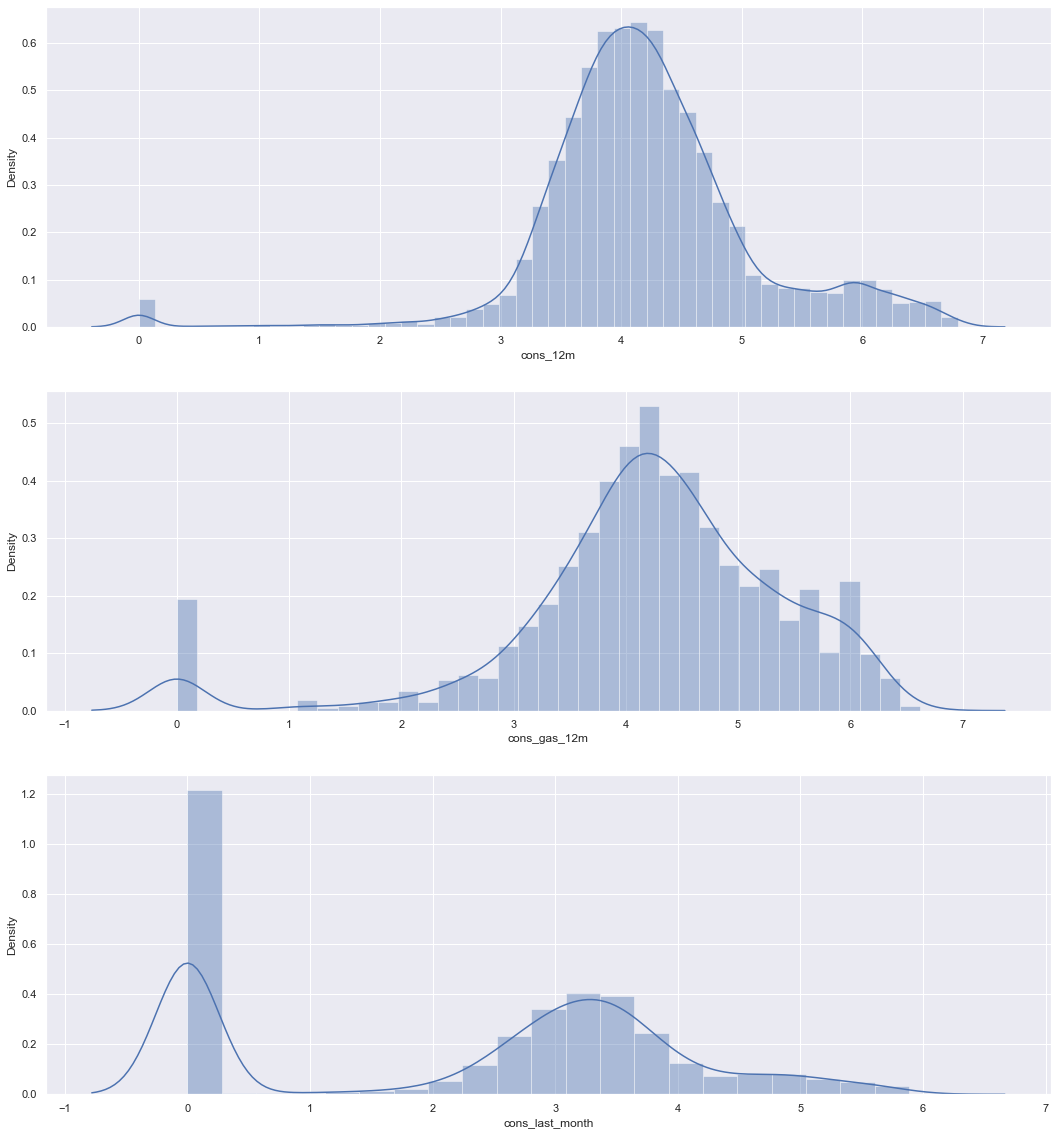

In [299]:
fig, axs = plt.subplots(nrows=3, figsize=(18, 20))
# Plot histograms
sns.distplot((df["cons_12m"].dropna()), ax=axs[0])
sns.distplot((df[df["has_gas"]==1]["cons_gas_12m"].dropna()), ax=axs[1])
sns.distplot((df["cons_last_month"].dropna()), ax=axs[2])
plt.show()

### Correlations

Depending on the assumption of parametric predictive model, features should be independent between each other. Hence, <b>the correlations between features should be close to 0 </b> to avoid Multicollinearity. Also, if two of them have high correlation, it would imply that the two features contain similar information.On the other hand, <b>the features should have higher correlations with `churn`</b> as that means higher predictive power.

In [300]:
correlations= df.corr()


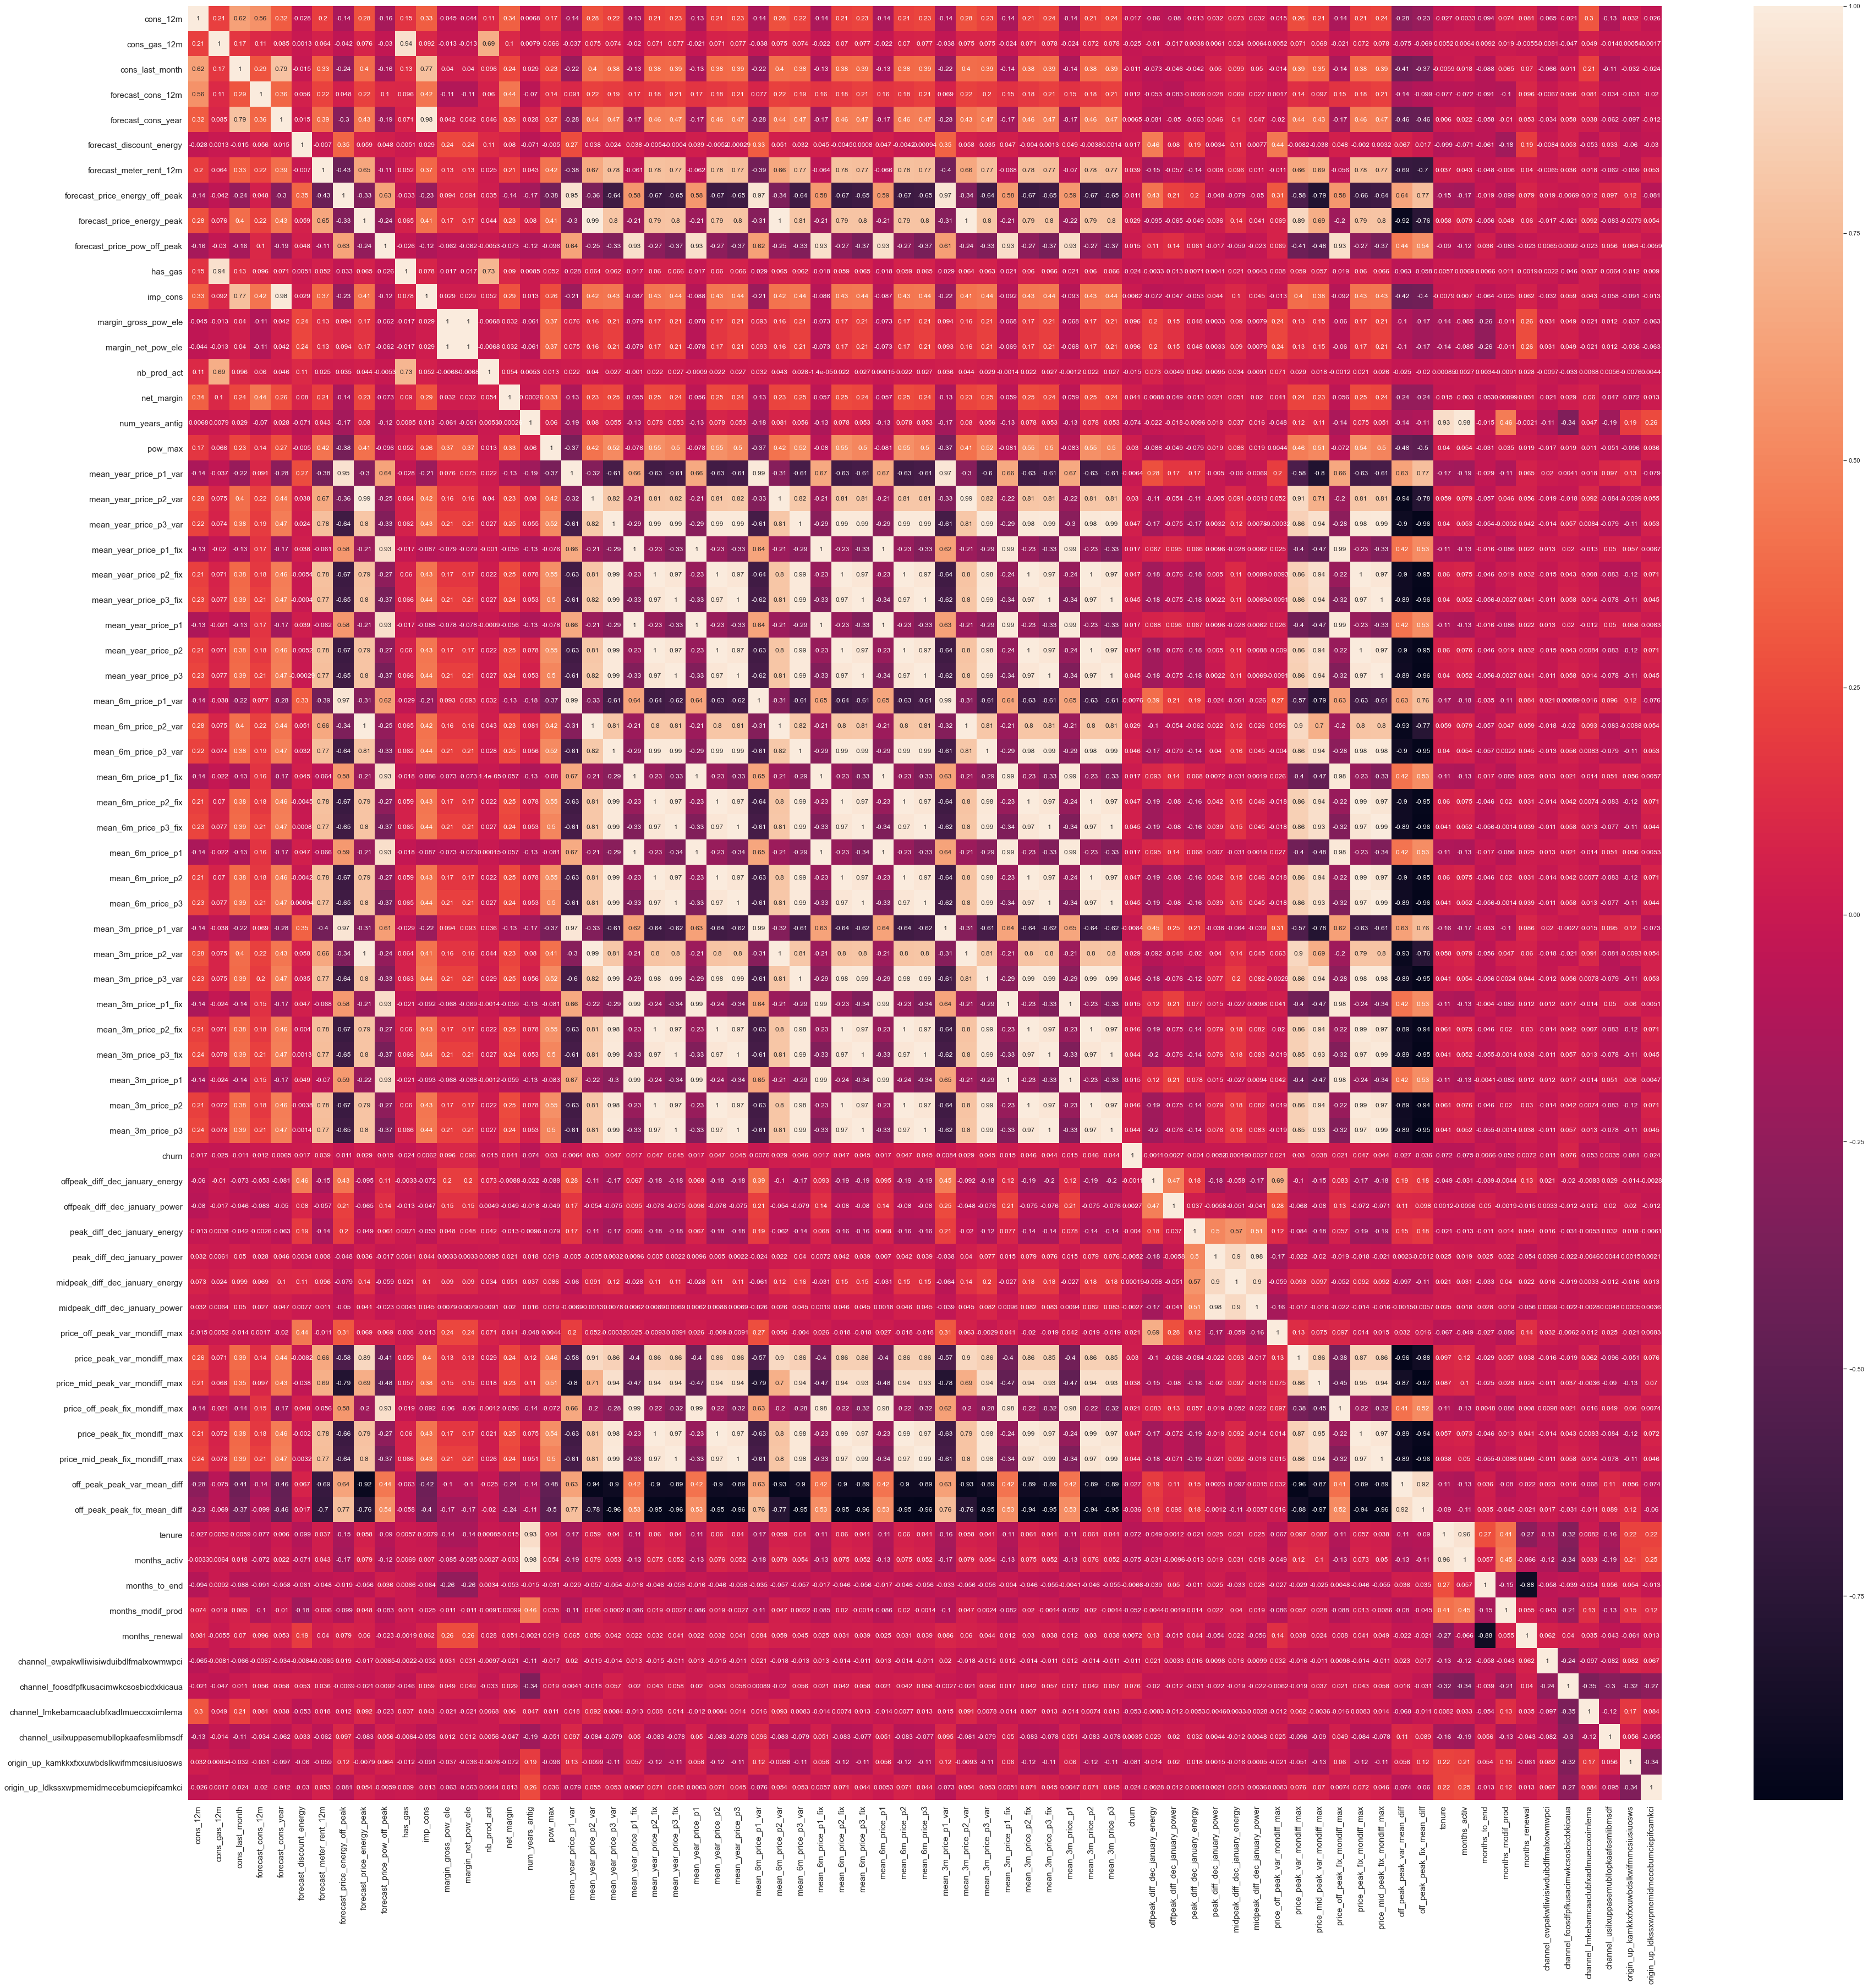

In [301]:
plt.figure(figsize=(60,60))
sns.heatmap(
    correlations,
    xticklabels=correlations.columns.values, 
    yticklabels=correlations.columns.values,
    annot=True,
    annot_kws={'size': 12})

plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

In [302]:
abs(correlations)>0.95


,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,...,months_activ,months_to_end,months_modif_prod,months_renewal,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci
cons_12m,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
cons_gas_12m,False,True,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
cons_last_month,False,False,True,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
forecast_cons_12m,False,False,False,True,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
forecast_cons_year,False,False,False,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
channel_foosdfpfkusacimwkcsosbicdxkicaua,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,True,False,False,False,False
channel_lmkebamcaaclubfxadlmueccxoimlema,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,True,False,False,False
channel_usilxuppasemubllopkaafesmlibmsdf,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [303]:
# Create correlation matrix
corr_matrix = df.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]

# Drop features 
#df.drop(to_drop, axis=1, inplace=True)

<ipython-input-303-2afdfee0d817>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))


In [304]:
to_drop

['imp_cons',
 'margin_net_pow_ele',
 'mean_year_price_p1_var',
 'mean_year_price_p2_var',
 'mean_year_price_p2_fix',
 'mean_year_price_p3_fix',
 'mean_year_price_p1',
 'mean_year_price_p2',
 'mean_year_price_p3',
 'mean_6m_price_p1_var',
 'mean_6m_price_p2_var',
 'mean_6m_price_p3_var',
 'mean_6m_price_p1_fix',
 'mean_6m_price_p2_fix',
 'mean_6m_price_p3_fix',
 'mean_6m_price_p1',
 'mean_6m_price_p2',
 'mean_6m_price_p3',
 'mean_3m_price_p1_var',
 'mean_3m_price_p2_var',
 'mean_3m_price_p3_var',
 'mean_3m_price_p1_fix',
 'mean_3m_price_p2_fix',
 'mean_3m_price_p3_fix',
 'mean_3m_price_p1',
 'mean_3m_price_p2',
 'mean_3m_price_p3',
 'midpeak_diff_dec_january_power',
 'price_off_peak_fix_mondiff_max',
 'price_peak_fix_mondiff_max',
 'price_mid_peak_fix_mondiff_max',
 'off_peak_peak_var_mean_diff',
 'off_peak_peak_fix_mean_diff',
 'months_activ']

In [305]:
df = df.drop(columns=['mean_year_price_p1_var',
 'mean_year_price_p2_var',
 'mean_year_price_p2_fix',
 'mean_year_price_p3_fix',
 'mean_year_price_p1',
 'mean_year_price_p2',
 'mean_year_price_p3',
 'mean_6m_price_p1_var',
 'mean_6m_price_p2_var',
 'mean_6m_price_p3_var',
 'mean_6m_price_p1_fix',
 'mean_6m_price_p2_fix',
 'mean_6m_price_p3_fix',
 'mean_6m_price_p1',
 'mean_6m_price_p2',
 'mean_6m_price_p3',
 'mean_3m_price_p1_var',
 'mean_3m_price_p2_var',
 'mean_3m_price_p3_var',
 'mean_3m_price_p1_fix',
 'mean_3m_price_p2_fix',
 'mean_3m_price_p3_fix',
 'mean_3m_price_p1',
 'mean_3m_price_p2',
 'mean_3m_price_p3'])

In [306]:
df.head()

,id,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,...,months_activ,months_to_end,months_modif_prod,months_renewal,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci
0,24011ae4ebbe3035111d65fa7c15bc57,0.000000,4.739944,0.000000,0.000000,0.000000,0.0,0.444045,0.114481,0.098142,...,30,5,2,6,0,1,0,0,0,0
1,d29c2c54acc38ff3c0614d0a653813dd,3.668479,0.000000,0.000000,2.280920,0.000000,0.0,1.237292,0.145711,0.000000,...,76,7,76,4,0,0,0,0,1,0
2,764c75f661154dac3a6c254cd082ea7d,2.736397,0.000000,0.000000,1.689841,0.000000,0.0,1.599009,0.165794,0.087899,...,68,3,68,8,0,1,0,0,1,0
3,bba03439a292a1e166f80264c16191cb,3.200029,0.000000,0.000000,2.382089,0.000000,0.0,1.318689,0.146694,0.000000,...,69,2,69,9,0,0,1,0,1,0
4,149d57cf92fc41cf94415803a877cb4b,3.646011,0.000000,2.721811,2.650065,2.721811,0.0,2.122969,0.116900,0.100015,...,71,2,71,9,0,0,0,0,1,0


## Modelling

Here I tried 2 models：Logistic Regression and Random Forest

Logistic regression is very useful and quite basic classification algorithms.

Random forest is a tree-based algorithm. In every tree-splitting, it picks the most important feature as classifier. It is more robust than decision trees as it can prevent overfitting.

### Logistic Regression

In [307]:
from sklearn.model_selection import train_test_split

In [308]:
# Make a copy of our data
train1_df = df.copy()

# Separate target variable from independent variables
y = df['churn']
X = df.drop(columns=['id', 'churn'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [309]:
from sklearn.linear_model import LogisticRegression

In [310]:
logmodel = LogisticRegression()
logmodel.fit(X_train,y_train)

/Users/jiemi/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [311]:
predictions = logmodel.predict(X_test)

In [312]:
from sklearn.metrics import classification_report

In [313]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.90      1.00      0.95      3957
           1       0.00      0.00      0.00       425

    accuracy                           0.90      4382
   macro avg       0.45      0.50      0.47      4382
weighted avg       0.82      0.90      0.86      4382



This model cannot predict churning clients. Let's move on to Random Forest model.

### Random Forest Model

In [314]:
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

In [315]:
model = RandomForestClassifier(
    n_estimators=1000
)
model.fit(X_train, y_train)

RandomForestClassifier(n_estimators=1000)

In [316]:
predictions = model.predict(X_test)

### Evaluation 

Metrics:
- Accuracy = the ratio of correctly predicted observations to the total observations
- Precision = the ability of the classifier to not label a negative sample as positive
- Recall = the ability of the classifier to find all the positive samples

Here, the problem is to predict the client to churn. Hence, recall of `1` is the most important metrics to check. The closer it is to 1, the more accurate the model is to find clients to churn.

In [317]:
print(classification_report(y_test,predictions))

              precision    recall  f1-score   support

           0       0.91      1.00      0.95      3957
           1       0.72      0.05      0.10       425

    accuracy                           0.91      4382
   macro avg       0.81      0.53      0.53      4382
weighted avg       0.89      0.91      0.87      4382



In [318]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, predictions).ravel()

In [319]:
print(f"True positives: {tp}")
print(f"False positives: {fp}")
print(f"True negatives: {tn}")
print(f"False negatives: {fn}\n")

print(f"Accuracy: {metrics.accuracy_score(y_test, predictions)}")
print(f"Precision: {metrics.precision_score(y_test, predictions)}")
print(f"Recall: {metrics.recall_score(y_test, predictions)}")

True positives: 23
False positives: 9
True negatives: 3948
False negatives: 402

Accuracy: 0.9062072113190324
Precision: 0.71875
Recall: 0.05411764705882353


In [320]:
y_test.value_counts()

0    3957
1     425
Name: churn, dtype: int64

### Result Explaination

- Within the test set, there are about 10% clients are churners
- The recall of 1 is quite poor, which means it has weak ability to find clients to churn.

- True positives is churning client who are also predicted to churn, which is 23 out of 425 (total churners). It is quite poor.
- False positives is clients predicted to churn who actually did't churn. This value is 9 which is good.
- True negtives is clients who didn't churn who are also predicted not to churn. This value is 3948 out of 3957 which is good.
- False negatives is clients predicted not to churn who actually churned. This value is 402 out of 425 which means almost 95% of churning clients were not correctly predicted. 

- The high accuracy could be misleading because if we predict all `churn` to be 0 then we still have 90% accuracy but it can't solve the problem (predict churning clients)

Overall, clients who don't churn can be accurately predicted whereas clients who churn are not able to be predicted accurately. There is  high precentage of clients who are identified as not churning but should be identified as churning. <b>This in turn tells me that the current set of features are not discriminative enough to clearly distinguish between churners and non-churners.</b>



### Feature Importance

In the Random Forest case, the feature importance represents the number of times each feature is used for splitting across all trees. (the most discriminative feature for each splitting.)

In [333]:
feature_importances = pd.DataFrame({
    'features': X_train.columns,
    'importance': model.feature_importances_
}).sort_values(by='importance', ascending=True).reset_index()



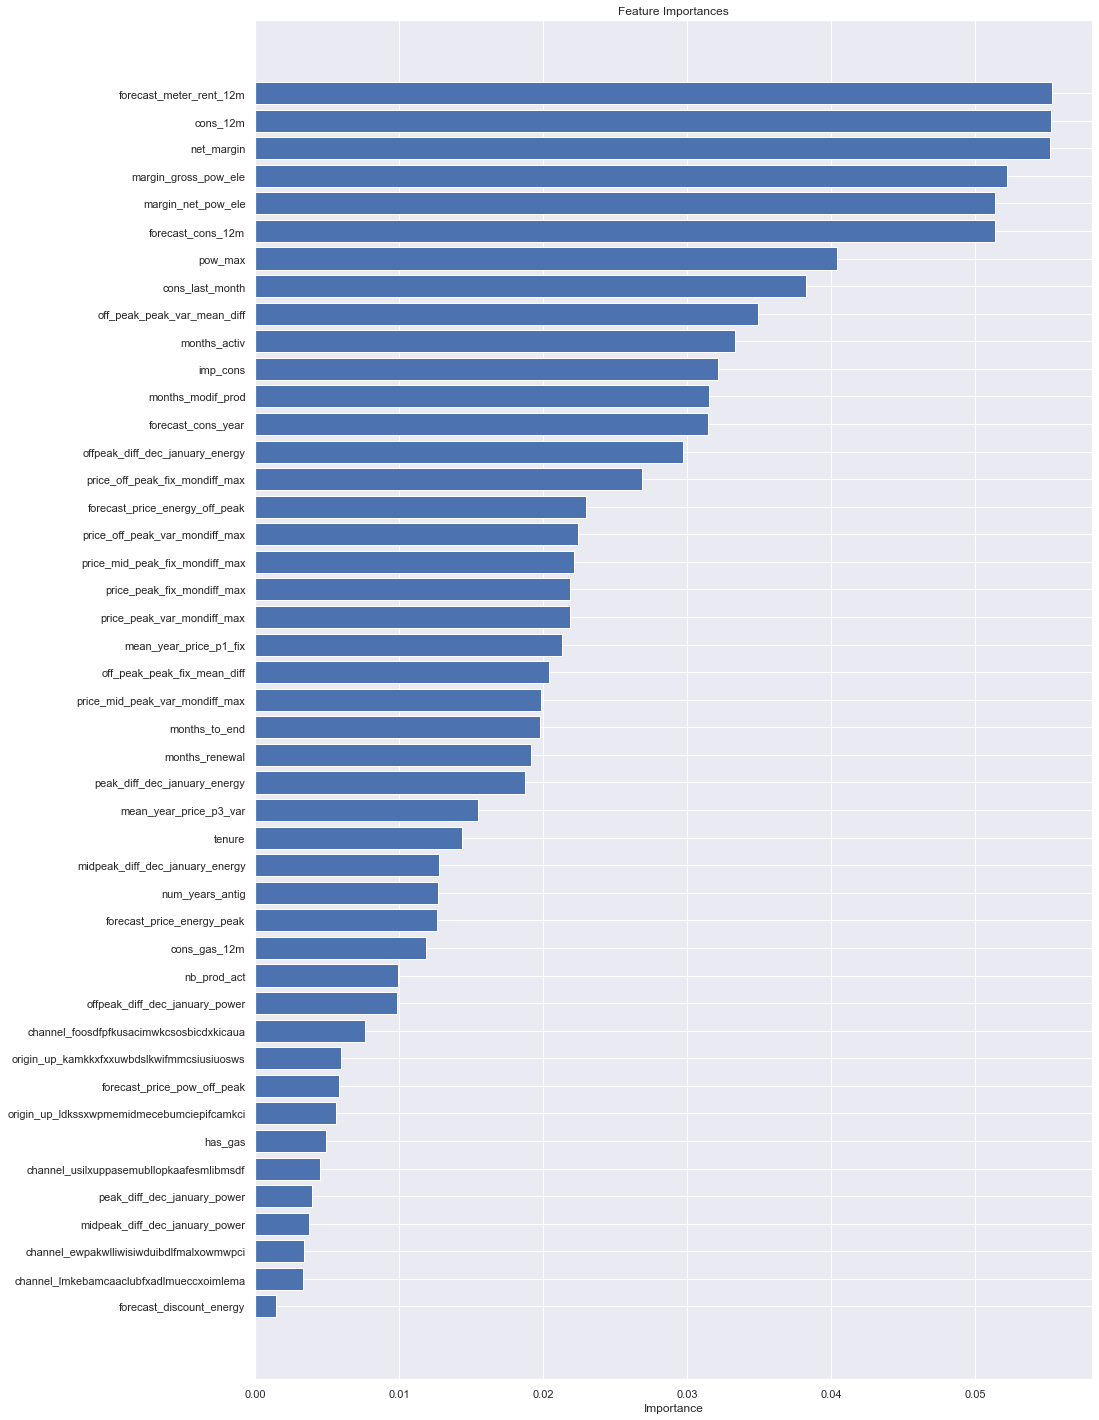

In [334]:
plt.figure(figsize=(15, 25))
plt.title('Feature Importances')
plt.barh(range(len(feature_importances)), feature_importances['importance'], color='b', align='center')
plt.yticks(range(len(feature_importances)), feature_importances['features'])
plt.xlabel('Importance')
plt.show()

From this chart, it shows:


- Forecasted bill of meter rental is top driver.
- Electricity consumption, margin and subscribed power are also influential drivers.
- Our price sensitivity features are scattered around but are not the main driver for a customer churning.

Back to the original hypothesis:

 > Is churn driven by the customers' price sensitivity?
 
 Based on the output of feature importance, price sensitivity is not a main driver but a weaker contributor. However, to arrive a conclusive result, more experiementation is needed.

In [335]:
# the probability of 0 and 1
proba_predictions = model.predict_proba(X_test)
# the probability of 1
probabilities = proba_predictions[:, 1]

In [340]:
X_test = X_test.reset_index()
X_test.drop(columns='index', inplace=True)

In [343]:
X_test['churn'] = predictions.tolist()
X_test['churn_probability'] = probabilities.tolist()
X_test.to_csv('out_of_sample_data_with_predictions.csv')

In [344]:
X_test

,cons_12m,cons_gas_12m,cons_last_month,forecast_cons_12m,forecast_cons_year,forecast_discount_energy,forecast_meter_rent_12m,forecast_price_energy_off_peak,forecast_price_energy_peak,forecast_price_pow_off_peak,...,months_modif_prod,months_renewal,channel_ewpakwlliwisiwduibdlfmalxowmwpci,channel_foosdfpfkusacimwkcsosbicdxkicaua,channel_lmkebamcaaclubfxadlmueccxoimlema,channel_usilxuppasemubllopkaafesmlibmsdf,origin_up_kamkkxfxxuwbdslkwifmmcsiusiuosws,origin_up_ldkssxwpmemidmecebumciepifcamkci,churn,churn_probability
0,3.731347,4.157003,2.707570,2.888292,2.707570,0.0,1.286007,0.137153,0.000000,44.311378,...,3,1,0,1,0,0,0,0,0,0.096
1,3.171726,4.888073,2.418301,2.349375,2.418301,0.0,1.288249,0.145711,0.000000,44.311378,...,54,5,0,1,0,0,0,0,0,0.168
2,3.237795,0.000000,0.000000,2.417256,0.000000,0.0,0.123852,0.144039,0.000000,46.305378,...,2,0,0,0,0,1,1,0,0,0.020
3,3.726075,0.000000,2.929930,2.902210,2.929930,0.0,1.299289,0.143227,0.000000,44.311378,...,1,0,0,0,0,0,0,0,0,0.119
4,4.204690,0.000000,3.161967,3.010821,2.926857,0.0,2.118695,0.120372,0.103487,40.606701,...,34,10,0,1,0,0,0,0,0,0.199
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4377,3.667173,4.533556,0.000000,2.674098,0.000000,0.0,2.076386,0.118065,0.101176,40.606701,...,7,0,0,1,0,0,0,0,0,0.307
4378,4.470190,0.000000,3.372175,3.473938,3.372175,0.0,2.114744,0.114667,0.099548,40.606701,...,2,1,0,0,0,1,0,0,0,0.124
4379,3.313867,0.000000,2.184691,2.417920,2.184691,0.0,1.185825,0.165793,0.088539,44.311378,...,15,3,0,1,0,0,0,0,0,0.066
4380,2.931458,0.000000,0.000000,2.113576,0.000000,0.0,1.132260,0.146694,0.000000,44.311378,...,18,9,0,0,0,0,0,0,0,0.097
